# Expected structure of folder:

```
ada-2024-project-outliars/
    ├── analysis.ipynb
    └── data/
        ├── paths-and-graph
            ├── articles.tsv
            ├── categories.tsv
            ├── links.tsv
            ├── paths_finished.tsv
            ├── paths_unfinished.tsv
            ├── shortest-path-distance-matrix.txt
        ├── plaintext_articles/
            └── ...
        └── articles_html
            └── css
            ├── images
            ├── js
            ├── wp
            ├── index.htm
```

# Loading the data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from urllib.parse import unquote
import seaborn as sns

## Loading article names

In [2]:
articles_df = pd.read_csv("data/paths-and-graph/articles.tsv", sep = "\t", comment = '#', header = None)
articles_df.columns = ['article_name']

# Decode names
articles_df['article_name'] = articles_df['article_name'].apply(unquote) 

print(articles_df.shape)
articles_df.head()

(4604, 1)


,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


## Loading categories for each article

In [3]:
categories_df = pd.read_csv("data/paths-and-graph/categories.tsv", sep = "\t", comment = '#', header = None)
categories_df.columns = ['article_name', 'category']

categories_df.head()

,article_name,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [4]:
# Decode article names
categories_df['article_name'] = categories_df['article_name'].apply(unquote)

# Split the 'category' column into multiple columns (one for each level of category)
df_split = categories_df['category'].str.split('.', expand=True).drop(columns=[0])

# Rename the columns to represent each level
df_split.columns = ['Level_1', 'Level_2', 'Level_3']

# Join the new columns with starting dataframe
categories_df = categories_df.drop(columns = ['category']).join(df_split)

print(categories_df.shape)
categories_df.head()

(5204, 4)


,article_name,Level_1,Level_2,Level_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None


## Loading existing links between articles

In [4]:
links_df = pd.read_csv("data/paths-and-graph/links.tsv", sep = "\t", comment = '#', header = None)
links_df.columns = ['source', 'target']

# Decode article names
links_df = links_df.map(unquote)

print(links_df.shape)
links_df.head()

(119882, 2)


,source,target
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [5]:
# Initialize adjacency matrix 
articles = articles_df['article_name'].tolist()
adj_matrix = pd.DataFrame(0, index=articles, columns=articles)

# Add existing links
for _, row in links_df.iterrows():
    source, target = row['source'], row['target']
    adj_matrix.loc[source, target] = 1

print(adj_matrix.shape)
adj_matrix.head()

(4604, 4604)


,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Åland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Édouard_Manet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Éire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Óengus_I_of_the_Picts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Loading data about finished paths

In [9]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

print(finished_df.shape)
finished_df.head()

(51318, 5)


,hashIP,timestamp,duration,path,difficulty_rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [10]:
finished_df = pd.read_csv("data/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

# Decode article names and transform path into list
finished_df['path'] = finished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate path length
finished_df['path_length'] = finished_df['path'].apply(len)

# Calculate number of backward clicks in each path
finished_df['numBackward'] = finished_df['path'].apply(lambda a: a.count("<"))

finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,numBackward
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


## Loading data about unfinished paths

In [7]:
unfinished_df = pd.read_csv("data/paths_unfinished.tsv", sep = "\t", comment = '#', header = None)
unfinished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'target_article', 'type_end']

# Decode article names and transform path to list
unfinished_df['path'] = unfinished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate length of unfinished paths
unfinished_df['path_length'] = unfinished_df['path'].apply(len)

# Calculate number of backward clicks
unfinished_df['numBackward'] = unfinished_df['path'].apply(lambda a: a.count("<"))

unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,numBackward
0,2426091a53125110,1297054935,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,1297055651,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,1297094761,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


## Loading data about shortest paths between articles (Floyd-Warshall algorithm)

In [8]:
# Open text file with distances
with open('data/shortest-path-distance-matrix.txt', 'r') as file:
    lines = file.readlines()

# Skip metadata lines
lines = lines[17:]

# Transform each line into a list of distances
distances = []
for line in lines:
    # Treat each character as a distance
    distances.append([np.nan if char == '_' else int(char) for char in line.strip()])

# Retrieve list of article names
article_names = articles_df['article_name'].tolist()

# Ensure the number of articles in articles_df matches the number of distances
assert len(article_names) == len(distances)

# Create the distance matrix dataframe
distance_df = pd.DataFrame(distances, columns=article_names, index=article_names)

distance_df.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


# Analysing the data

## Categories statistics

In [9]:
len(articles_df) # number of articles

4604

In [10]:
# group by article to see statistics of each category and its levels
article_categories = categories_df.groupby('article_name')[['Level_1', 'Level_2', 'Level_3']] 
print(article_categories.count()) # categories of each article

                        Level_1  Level_2  Level_3
article_name                                     
10th_century                  1        1        0
11th_century                  1        1        0
12th_century                  1        1        0
13th_century                  1        1        0
14th_century                  1        1        0
...                         ...      ...      ...
Åland                         2        1        1
Édouard_Manet                 1        1        0
Éire                          2        1        1
Óengus_I_of_the_Picts         2        2        1
€2_commemorative_coins        1        1        0

[4598 rows x 3 columns]


In [11]:
len(article_categories)

4598

Some articles do not appear in the categories dataframe.

In [12]:
articles_with_cats = list(article_categories.groups.keys()) # get articles that appear in category_df
for name in articles_df.article_name.values: # find articles that do not appear in category_df
    if name not in articles_with_cats:
        print(name)

Directdebit
Donation
Friend_Directdebit
Pikachu
Sponsorship_Directdebit
Wowpurchase


The category of these articles is unknown.

In [13]:
# overview of categories of each article
# create new dataframe where each row is one article with information about its categories
articles = articles_df['article_name'].tolist()
article_category_data = pd.DataFrame(list(), index=articles, columns=['Level_1_cats', 'Level_2_cats', 'Level_3_cats', 'total_def_cats'])

for group, vals in article_categories:
    article_category_data.loc[group, 'Level_1_cats'] = (vals['Level_1'].tolist())
    article_category_data.loc[group, 'Level_2_cats'] = (vals['Level_2'].tolist())
    article_category_data.loc[group, 'Level_3_cats'] = (vals['Level_3'].tolist())
    article_category_data.loc[group, 'total_def_cats'] = vals.shape[0]

In [14]:
article_category_data.head()

,Level_1_cats,Level_2_cats,Level_3_cats,total_def_cats
Áedán_mac_Gabráin,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2
Åland,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Édouard_Manet,[People],[Artists],[None],1
Éire,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Óengus_I_of_the_Picts,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2


In [15]:
article_category_data.groupby('total_def_cats')['Level_1_cats'].count() # see number of categories per article distribution

total_def_cats
1    4000
2     590
3       8
Name: Level_1_cats, dtype: int64

In [16]:
# for each category level, print percentage of NaN values
print("Level_1 :", 100*(categories_df.shape[0] - categories_df.Level_1.count())/categories_df.shape[0],"%")
print("Level_2 :",100*(categories_df.shape[0] - categories_df.Level_2.count())/categories_df.shape[0], "%")
print("Level_3 :", 100*(categories_df.shape[0] - categories_df.Level_3.count())/categories_df.shape[0], "%")

Level_1 : 0.0 %
Level_2 : 5.265180630284396 %
Level_3 : 71.52190622598002 %


A defined category of an article is composed of 3 levels, where level 1 is the most general category, level 2 is a subcategory of level 1, and level 3 is a subcategory of level 2. A defined category cannot have a value of level 2 without having a value of level 1, and the same goes with level 3 and level 2. A defined category must at least have a value in the level 1.

Each article can have multiple defined categories, or none. The total number of articles in the dataset is **4604**. Six articles do not have any defined category. 4000 articles have one defined category, 590 have two defined categories, and 8 have three defined categories.

For all existing defined categories of all articles, the level 1 value is always present. Level 2 value is missing in 5.26% of cases, while level 3 is missing in 71.52% of cases.

In [19]:
print("Number of unique categories for each category level")
print("Level_1: ", len(categories_df.Level_1.unique()))
print("Level_2: ", len(categories_df.Level_2.unique()))
print("Level_3: ", len(categories_df.Level_3.unique()))

print(f"Unique Level 1 categories\n {categories_df.Level_1.unique()}\n")
print(f"First 20 unique Level 2 categories\n {categories_df.Level_2.unique()[0:20]}\n")
print(f"Unique Level 3 categories\n {categories_df.Level_3.unique()}")

Number of unique categories for each category level
Level_1:  15
Level_2:  102
Level_3:  28
Unique Level 1 categories
 ['History' 'People' 'Countries' 'Geography' 'Business_Studies' 'Science'
 'Everyday_life' 'Design_and_Technology' 'Music' 'IT'
 'Language_and_literature' 'Mathematics' 'Religion' 'Art' 'Citizenship']

First 20 unique Level 2 categories
 ['British_History' 'Historical_figures' None 'European_Geography'
 'Artists' 'Currency' 'General_history' 'Military_History_and_War'
 'Physics' 'Sports_events' 'Storms' 'Recent_History'
 'Geology_and_geophysics' 'Natural_Disasters' 'Railway_transport'
 'Sports_and_games_people' 'Biology' 'Performers_and_composers'
 'Computing_hardware_and_infrastructure' 'Companies']

Unique Level 3 categories
 ['British_History_1500_and_before_including_Roman_Britain' None
 'European_Countries' 'Space_Astronomy' 'Health_and_medicine'
 'General_Physics' 'Mammals' 'Plants' 'British_History_15001750'
 'Asian_Countries' 'Middle_Eastern_Countries' 'Chemical

We have 15 possible values for level 1 categories, 102 for level 2 categories and 28 for level 3 categories.

In [18]:
# overview of existing categories
pd.set_option('display.max_rows', None)

# Number of articles belonging to a Level 1 category, and for each level 1 value % of articles that have non null value of corresponding Level_2 category
level_1_counts = pd.DataFrame(categories_df.groupby('Level_1').size())
level_1_counts.columns = ['totalEntries']
level_1_counts['percNonNullLevel2'] = 100 * categories_df.groupby('Level_1')['Level_2'].count() / level_1_counts.totalEntries

print(level_1_counts)

# Number of articles belonging to a Level 2 category, and for each level 2 value % of articles that have non null value of corresponding Level_3 category
level_2_counts = pd.DataFrame(categories_df.groupby(['Level_1', 'Level_2']).size())
level_2_counts.columns = ['totalEntries']
level_2_counts['percNonNullLevel3'] = 100 * categories_df.groupby(['Level_1', 'Level_2'])['Level_3'].count() / level_2_counts.totalEntries

print(level_2_counts)

# Number of articles belonging to a Level 3 category
level_3_counts = categories_df.groupby(['Level_1', 'Level_2', 'Level_3']).size()
print(level_3_counts)

                         totalEntries  percNonNullLevel2
Level_1                                                 
Art                                38              100.0
Business_Studies                   88              100.0
Citizenship                       224              100.0
Countries                         229                0.0
Design_and_Technology             254              100.0
Everyday_life                     374              100.0
Geography                        1084              100.0
History                           545              100.0
IT                                 85              100.0
Language_and_literature           196              100.0
Mathematics                        45                0.0
Music                              97              100.0
People                            689              100.0
Religion                          134              100.0
Science                          1122              100.0
                               

For *Level_1* categories, we observe that for each individual category, all articles of this category either all have a corresponding *Level_2* category value specified, or they all don't. This is not the case when observing *Level_2* categories, where for some of them (f.e. *African_Geography*) articles of this category may or may not have a corresponding *Level_3* category specified.  

Specifically, when looking at *Level_1* categories, all the articles in the categories *Countries* and *Mathematics* do not have corresponding *Level_2* subcategories specified. For the *Science* category (*Level_1*), all articles have both corresponding *Level_2* subcategory and *Level_3* subcategory specified. In the *History* category (*Level_1*), only some articles of the subcategory *British_History* (*Level_2*) have specified values for corresponding *Level_3* categories. This is also the case for the *Level_2* categories *African_Geography, Central_and_South_American_Geography, European_Geography, Geography_of_Asia, Geography_of_the_Middle_East* that are subcategories of the *Level_1 Geography* category. For all articles that have other values of the *Level_2* category, there are no corresponding *Level_3* subcategories specified.

## Analysing links

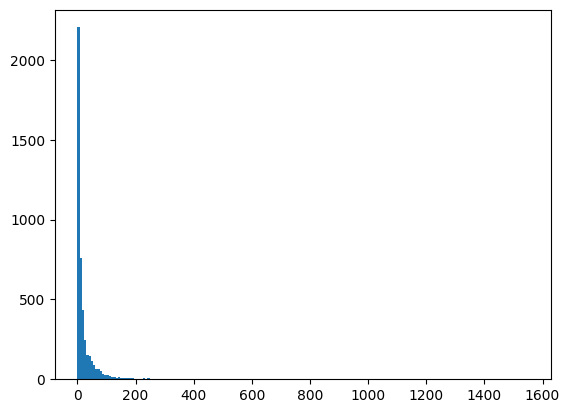

In [19]:
# create adjacency matrix for articles, id is the source, 1 if source has link to corresponding article
outgoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 0) # distribution of number of outgoing links per article
bins_300 = plt.hist(outgoing_links, bins = 200)
plt.show()

In [20]:
outgoing_links

Áedán_mac_Gabráin                                                                         0
Åland                                                                                     0
Édouard_Manet                                                                             0
Éire                                                                                      0
Óengus_I_of_the_Picts                                                                     0
€2_commemorative_coins                                                                    0
10th_century                                                                             65
11th_century                                                                             57
12th_century                                                                             85
13th_century                                                                             84
14th_century                                                                    

In [21]:
outgoing_links.value_counts().sort_index()

0       469
1       442
2       308
3       281
4       200
5       173
6       160
7       172
8       126
9       121
10      107
11       87
12       83
13       86
14       69
15       82
16       68
17       65
18       58
19       51
20       66
21       40
22       37
23       47
24       37
25       40
26       34
27       32
28       24
29       28
30       27
31       23
32       29
33       18
34       25
35       19
36       15
37       28
38       20
39       23
40       13
41       17
42       20
43       28
44       14
45       16
46       13
47       13
48       20
49       12
50       15
51        8
52       11
53       14
54       19
55       10
56       11
57       10
58        9
59       16
60       13
61        9
62       13
63       13
64        7
65       14
66        8
67        6
68        9
69        7
70        5
71        7
72       14
73        6
74        5
75        6
76       13
77        9
78        3
79        8
80        6
81        6
82        3
83  

The dataset containts 469 articles that have 0 outgoing links. There is one article (outlier) that contains 1551 outgoing links.

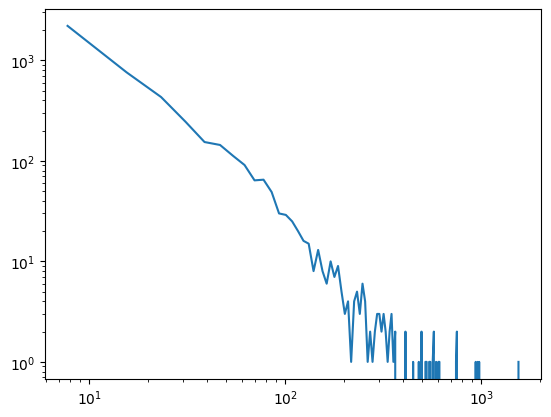

In [22]:
plt.loglog(bins_300[1][1:], bins_300[0])
plt.show()

We can see the distribution of number of outgoing links follows a powerlaw distribution, so if we use this as a feature, we have to use the logarithmic value.

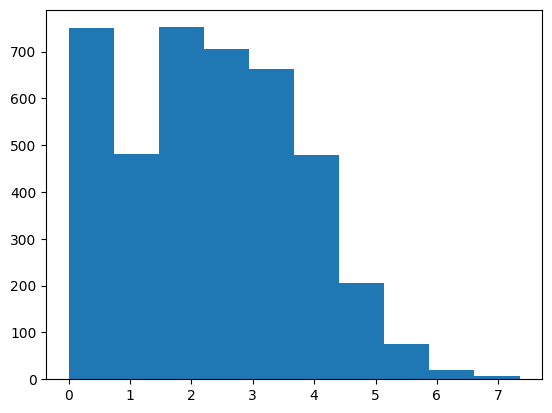

In [23]:
outgoing_links = adj_matrix.apply(lambda a: np.log(a.sum()) if a.sum() > 0 else None, axis = 0)
outgoing_links.dropna(inplace=True)
plt.hist(outgoing_links)
plt.show()

## Analysing finished paths

In [24]:
finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,numBackward
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


### Path length

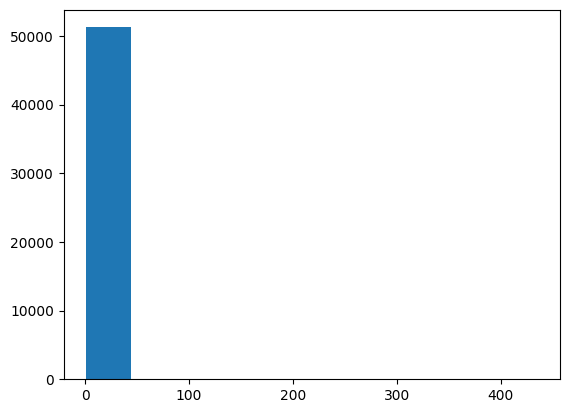

In [25]:
plt.hist(finished_df.path_length)
plt.show()

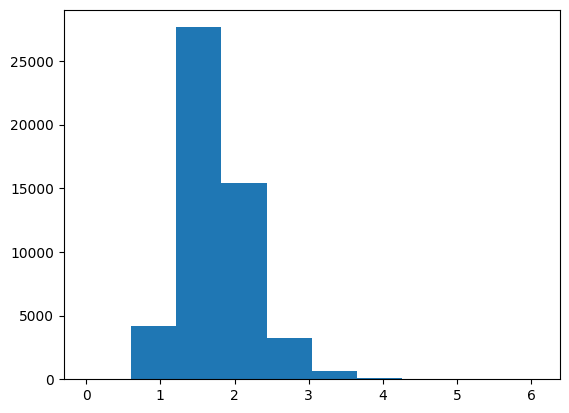

In [26]:
plt.hist(finished_df.path_length.apply(np.log))
plt.show()

In [27]:
finished_df.path_length.describe()

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

In [28]:
finished_df.path_length.value_counts().sort_index()

path_length
1         11
2        798
3       3424
4       8558
5      10941
6       8137
7       5868
8       3954
9       2650
10      1713
11      1256
12       867
13       623
14       462
15       359
16       275
17       232
18       183
19       151
20       119
21       105
22        75
23        65
24        60
25        60
26        40
27        36
28        25
29        25
30        24
31        16
32        25
33        21
34        15
35        14
36        10
37        12
38         9
39        11
40         4
41         3
42         2
43         4
44         4
45         3
46         5
47         5
48         3
49         6
50         6
51         1
52         2
53         2
54         6
55         2
56         2
57         1
58         1
60         3
61         1
62         2
63         1
65         2
66         1
67         1
69         1
70         2
71         1
72         1
77         1
80         1
85         1
86         1
87         1
96         2
99         1


We can see there are outliers, since the max is 435 and the mean is 6.75. We can also see the distribution is skewed.

### Backward option

(array([5.037e+04, 6.680e+02, 1.890e+02, 3.900e+01, 2.500e+01, 1.100e+01,
        7.000e+00, 3.000e+00, 4.000e+00, 2.000e+00]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <BarContainer object of 10 artists>)

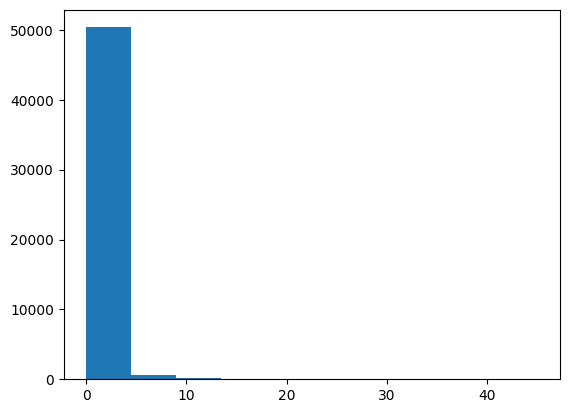

In [29]:
plt.hist(finished_df.numBackward)

In [30]:
finished_df.num_backward.describe()

count    51318.000000
mean         0.400659
std          1.451216
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         45.000000
Name: numBackward, dtype: float64

In [31]:
finished_df.num_backward.value_counts().sort_index()

numBackward
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
17        5
18        5
19        7
20        3
21        3
22        7
23        6
24        1
25        2
26        2
27        2
28        3
29        2
32        2
35        1
36        2
38        1
40        1
45        2
Name: count, dtype: int64

In [32]:
print("The backward option was not used at all in ", 100*finished_df.num_backward.value_counts().sort_index().iloc[0] / finished_df.shape[0] , " % of missions")

The backward option was not used at all in  82.4720371019915  % of missions


In most finished missions, the backward option was not used at all. The distribution of backward uses per mission is therefore also skewed.

### Duration

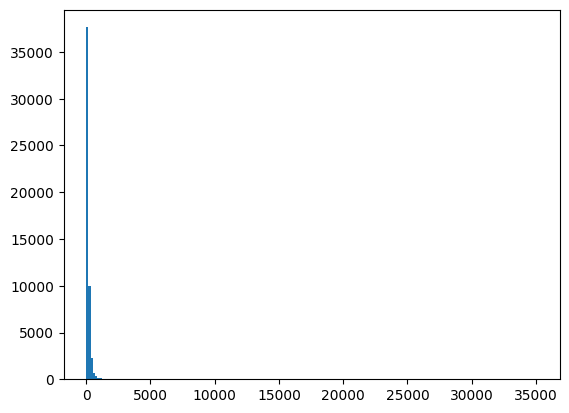

In [33]:
bins_200 = plt.hist(finished_df.duration, bins = 200)
plt.show()

In [34]:
finished_df.duration.describe()

count    51318.000000
mean       158.276199
std        360.841904
min          0.000000
25%         60.000000
50%        107.000000
75%        183.000000
max      35091.000000
Name: duration, dtype: float64

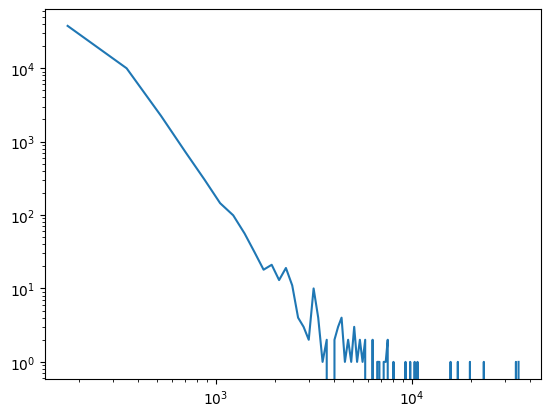

In [35]:
plt.loglog(bins_200[1][1:], bins_200[0])
plt.show()

The distribution of duration of mission in seconds is skewed and ressembles a powerlaw distribution, so we should apply the logarithmic function.

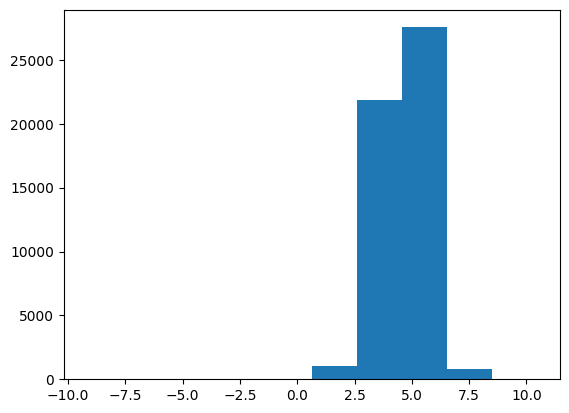

In [36]:
plt.hist(finished_df.duration.apply(lambda a: np.log(a + 1e-4)))
plt.show()

### Difficulty ratings

It is important to keep in mind that the given difficulty ratings are given by user who successfully finished the mission, and are not an objective difficulty measure.

In [37]:
finished_df.difficulty_rating.describe()

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: difficulty_rating, dtype: float64

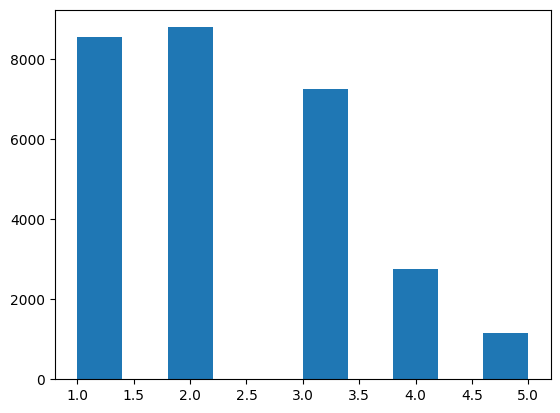

In [38]:
plt.hist(finished_df.difficulty_rating)
plt.show()

In [39]:
finished_df.difficulty_rating.value_counts().sort_index()

difficulty_rating
1.0    8542
2.0    8792
3.0    7261
4.0    2748
5.0    1158
Name: count, dtype: int64

In [40]:
print("Percentage of missing difficulty ratings: ", 100 * finished_df.difficulty_rating.isna().sum() / finished_df.difficulty_rating.shape, "%")

Percentage of missing difficulty ratings:  [44.46198215] %


We can see that in almost 45% of the cases, the user did not give a difficulty rating for the mission. Higher difficulty ratings are more rare.

### Correlations between path lenghts, duration, backward clicks and difficulty rating

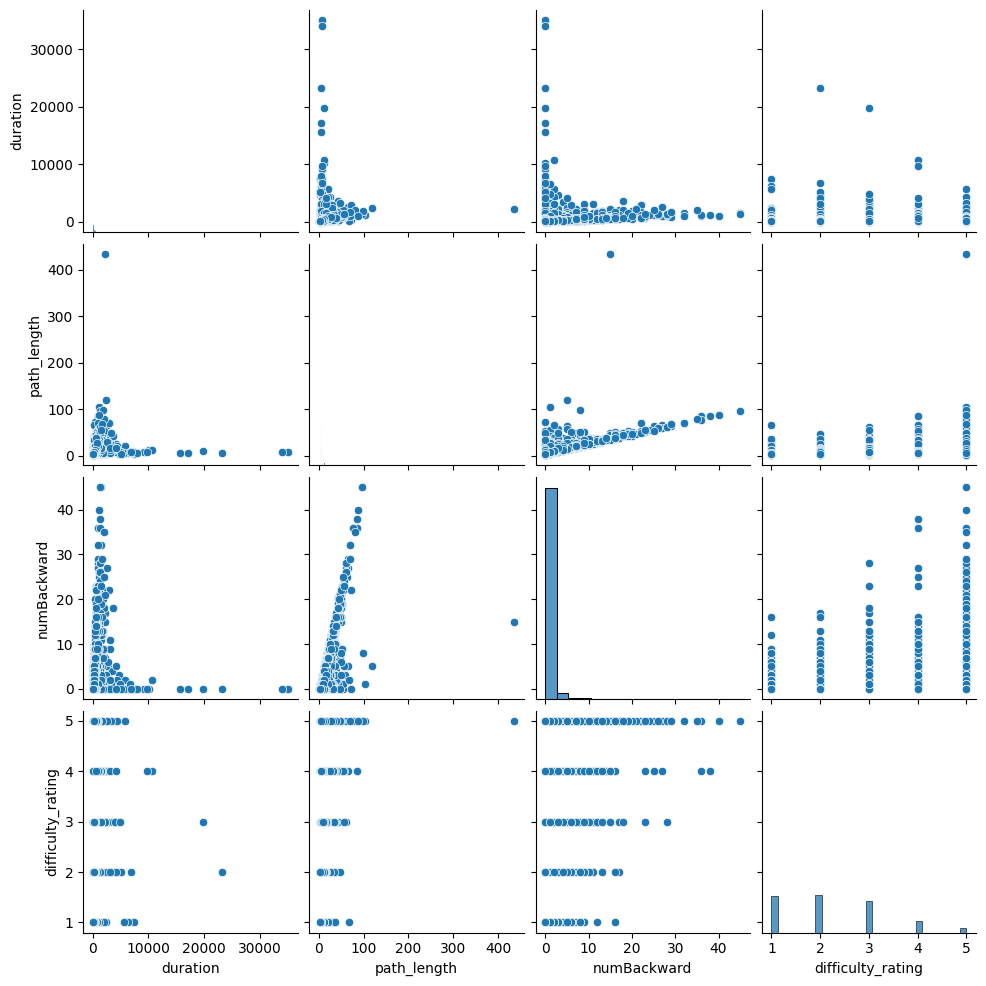

In [41]:
sns.pairplot(finished_df[['duration', 'path_length', 'num_backward', 'difficulty_rating']])
plt.show()

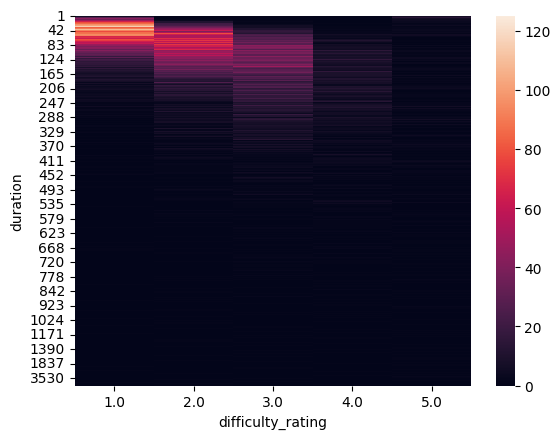

In [42]:
sns.heatmap(pd.crosstab(finished_df.duration, finished_df.difficulty_rating))
plt.show()

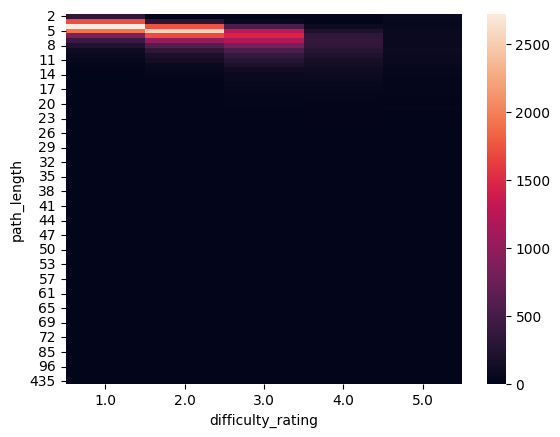

In [43]:
sns.heatmap(pd.crosstab(finished_df.path_length, finished_df.difficulty_rating))
plt.show()

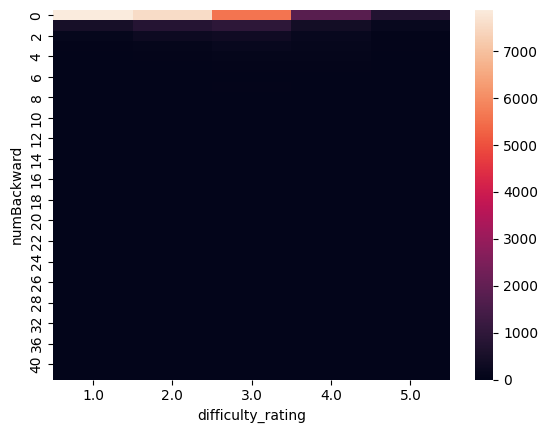

In [44]:
sns.heatmap(pd.crosstab(finished_df.num_backward, finished_df.difficulty_rating))
plt.show()

Ignoring the outliers, we can see a positive correlation between the difficulty rating and the duration and the path_length.

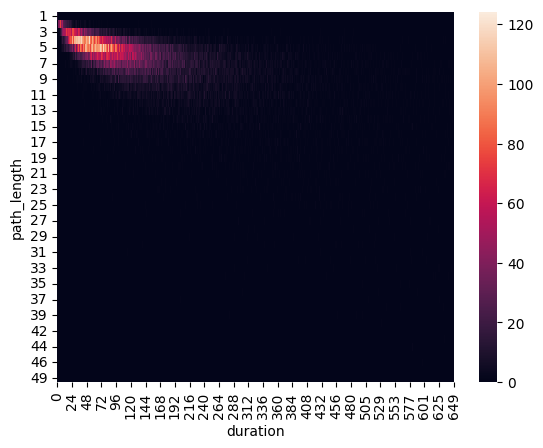

In [45]:
finished_df_copy = finished_df[(finished_df.path_length < 50) & (finished_df.duration < 650)]
sns.heatmap(pd.crosstab(finished_df_copy.path_length, finished_df_copy.duration))
plt.show()

In [46]:
finished_df[['duration', 'path_length', 'difficulty_rating', 'num_backward']].corr(method = 'pearson')

,duration,path_length,difficulty_rating,numBackward
duration,1.000000,0.279051,0.253637,0.199282
path_length,0.279051,1.000000,0.403749,0.718316
difficulty_rating,0.253637,0.403749,1.000000,0.233722
numBackward,0.199282,0.718316,0.233722,1.000000


## Analysing unfinished paths

In [47]:
unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,numBackward
0,2426091a53125110,1297054935,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,1297055651,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,1297094761,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


### Path length

In [48]:
unfinished_df.path_length.describe()

count    24875.000000
mean         5.197789
std          5.772234
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        235.000000
Name: path_length, dtype: float64

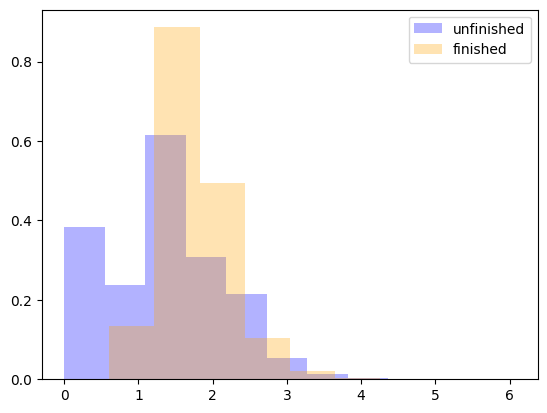

In [49]:
plt.hist(unfinished_df.path_length.apply(lambda a: np.log(a)), color = 'blue', label = 'unfinished',  alpha = 0.3, density = True)
plt.hist(finished_df.path_length.apply(lambda a: np.log(a)), color = 'orange', label = 'finished',  alpha = 0.3, density = True)
plt.legend()
plt.show()

While the median in finished lengths for the path length was 6, here it is 4, which suggests unfinished paths are shorter.

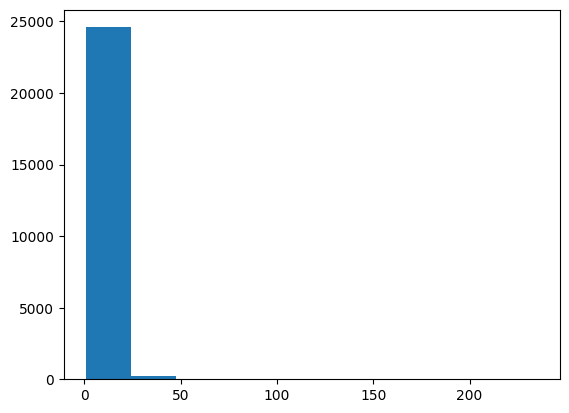

In [50]:
plt.hist(unfinished_df.path_length)
plt.show()

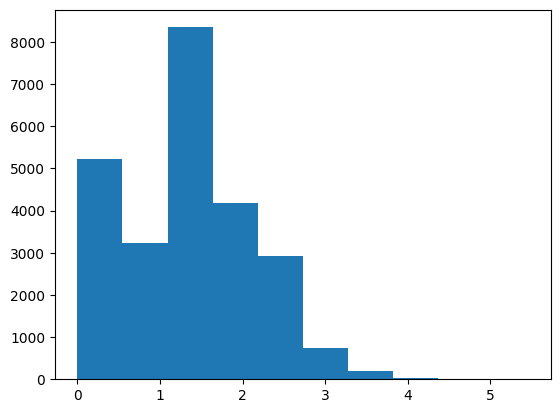

In [51]:
plt.hist(unfinished_df.path_length.apply(np.log))
plt.show()

The path lengths are again coming from a skewed distribution.

### Backward option

In [52]:
unfinished_df.numBackward.describe()

count    24875.000000
mean         0.518874
std          1.821074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         82.000000
Name: numBackward, dtype: float64

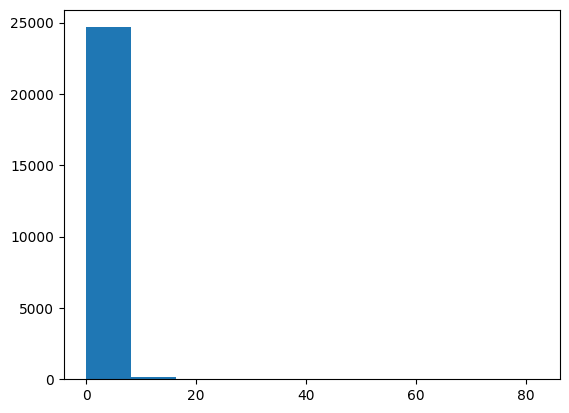

In [53]:
plt.hist(unfinished_df.numBackward)
plt.show()

In [54]:
print("The backward option was not used at all in ", 100*unfinished_df.numBackward.value_counts().sort_index().iloc[0] / unfinished_df.shape[0] , " % of missions")

The backward option was not used at all in  79.09145728643216  % of missions


The backward option was used only 3% more than in finished paths.

### Type of end

In [55]:
unfinished_df.type_end.value_counts().sort_index()

type_end
restart    15552
timeout     9323
Name: count, dtype: int64

In [56]:
print("The game ends because of a restart in ", 100* unfinished_df[unfinished_df.type_end == 'restart'].shape[0] / unfinished_df.shape[0] , "% of cases")

The game ends because of a restart in  62.52060301507538 % of cases


The game can end either because of a timeout, or because the player restarted the game.

### Duration

In [57]:
unfinished_df.duration.describe()

count    24875.000000
mean       835.296884
std        881.287961
min          4.000000
25%         86.000000
50%        261.000000
75%       1831.000000
max       9089.000000
Name: duration, dtype: float64

The duration in unfinished paths is significantly bigger than in finished paths, with a 75th percentile of 1831 seconds, compared to the previous of 183. The distribution is still skewed and has outliers.

(array([1.5306e+04, 2.7870e+03, 6.6510e+03, 1.0200e+02, 1.9000e+01,
        7.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.0000e+00, 9.1250e+02, 1.8210e+03, 2.7295e+03, 3.6380e+03,
        4.5465e+03, 5.4550e+03, 6.3635e+03, 7.2720e+03, 8.1805e+03,
        9.0890e+03]),
 <BarContainer object of 10 artists>)

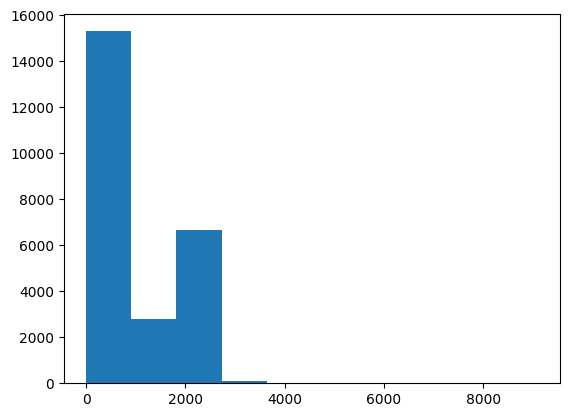

In [58]:
plt.hist(unfinished_df.duration)

However, we have to take into account that over 35% of unfinished missions ended in a timeout, so the duration in these cases is not relevant. We therefore analyse the duration again, removing the rows that ended in a timeout

In [59]:
ended_restart = unfinished_df[unfinished_df.type_end == 'restart']

In [60]:
ended_restart.duration.describe()

count    15552.000000
mean       176.575296
std        222.267962
min          4.000000
25%         48.000000
50%        114.000000
75%        224.000000
max       5263.000000
Name: duration, dtype: float64

The duration is shorter for the 25th percentile (it was 60 seconds before), but is bigger for the 75th percentile (was 183 before).

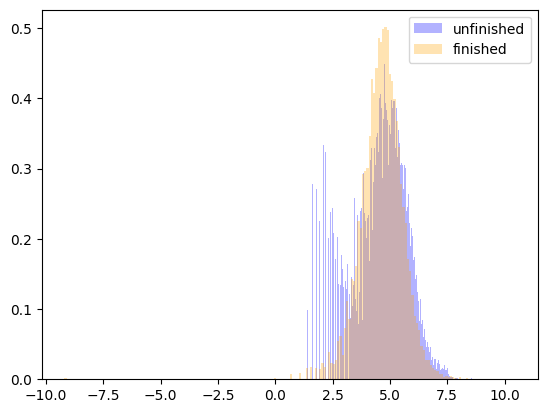

In [61]:
plt.hist(ended_restart.duration.apply(lambda a: np.log(a + 1e-4)), color = 'blue', label = 'unfinished', bins = 200, alpha = 0.3, density = True)
plt.hist(finished_df.duration.apply(lambda a: np.log(a + 1e-4)), color = 'orange', label = 'finished', bins = 200, alpha = 0.3, density = True)
plt.legend()
plt.show()

### Correlation between duration, path length and backward option

We will only consider rows that ended by a restart so that we make sure the duration is relevant.

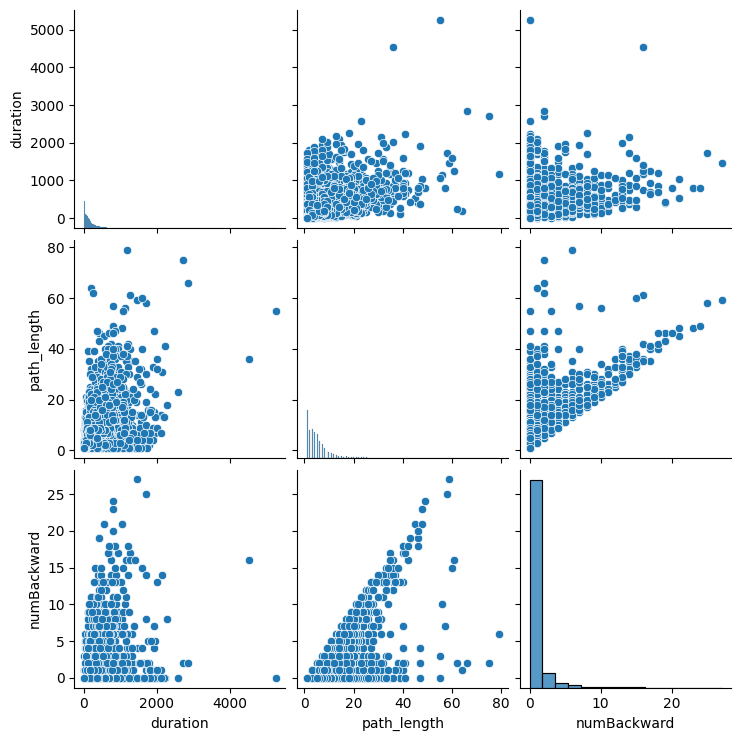

In [62]:
sns.pairplot(ended_restart[['duration', 'path_length', 'numBackward', 'type_end']])
plt.show()

In [63]:
ended_restart[['duration', 'path_length', 'numBackward']].corr(method = 'pearson')

,duration,path_length,numBackward
duration,1.000000,0.609426,0.353296
path_length,0.609426,1.000000,0.684169
numBackward,0.353296,0.684169,1.000000


We see a higher correlation than before between the path length and the duration and between the path length and the number of backward clicks.

### Analysing missions 

Our goal is to analyse the distribution of played missions depending on source and goal article, if the difficulty rating depends more on the player or on the source/goal article, how much data we have for each source/goal pair etc

In [64]:
print(unfinished_df.head())
print(finished_df.head())

             hashIP   timestamp  duration  \
0  2426091a53125110  1297054935      1804   
1  26141fd878806294  1297055651      1805   
2  2b015fb8181c48f2  1297090819      1818   
3  53a53bc244e08a6a  1297094761        49   
4  53a53bc244e08a6a  1297099105      1808   

                                       path    target_article type_end  \
0                          [Obi-Wan_Kenobi]         Microsoft  timeout   
1                           [Julius_Caesar]           Caracas  timeout   
2  [Malawi, Democracy, Alexander_the_Great]     First_Crusade  timeout   
3                                [Paraguay]  Mount_St._Helens  restart   
4                       [Paraguay, Bolivia]  Mount_St._Helens  timeout   

   path_length  numBackward  
0            1            0  
1            1            0  
2            3            0  
3            1            0  
4            2            0  
             hashIP   timestamp  duration  \
0  6a3701d319fc3754  1297740409       166   
1  3824310e536

In [86]:
unfinished_mod = unfinished_df.copy()
unfinished_mod['source_article'] = unfinished_mod.path.apply(lambda a: a[0])
unfinished_mod['finished'] = False
unfinished_mod = unfinished_mod.reindex(sorted(unfinished_mod.columns), axis=1)
unfinished_mod.head()
#unfinished_mod.shape[0]

,duration,finished,hashIP,numBackward,path,path_length,source_article,target_article,timestamp,type_end
0,1804,False,2426091a53125110,0,[Obi-Wan_Kenobi],1,Obi-Wan_Kenobi,Microsoft,1297054935,timeout
1,1805,False,26141fd878806294,0,[Julius_Caesar],1,Julius_Caesar,Caracas,1297055651,timeout
2,1818,False,2b015fb8181c48f2,0,"[Malawi, Democracy, Alexander_the_Great]",3,Malawi,First_Crusade,1297090819,timeout
3,49,False,53a53bc244e08a6a,0,[Paraguay],1,Paraguay,Mount_St._Helens,1297094761,restart
4,1808,False,53a53bc244e08a6a,0,"[Paraguay, Bolivia]",2,Paraguay,Mount_St._Helens,1297099105,timeout


In [87]:
finished_mod = finished_df.copy()
finished_mod['source_article'] = finished_mod.path.apply(lambda a: a[0])
finished_mod['target_article'] = finished_mod.path.apply(lambda a: a[-1])
finished_mod['finished'] = True
finished_mod = finished_mod.reindex(sorted(finished_mod.columns), axis=1)
finished_mod.head()
#finished_mod.shape[0]

,difficulty_rating,duration,finished,hashIP,numBackward,path,path_length,source_article,target_article,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,1297740409
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,1344753412
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,1349298640
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,1265613925
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,1366730828


In [88]:
# creating dataframe combining stats about finished and unfinished missions
games = pd.concat([finished_mod, unfinished_mod], ignore_index = True)
games.head()
#games.shape[0]

,difficulty_rating,duration,finished,hashIP,numBackward,path,path_length,source_article,target_article,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,1297740409,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,1344753412,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,1349298640,NaN
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,1265613925,NaN
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,1366730828,NaN


In [89]:
# creating dataframe that gives number of played games for each possible source/goal combination that was played at least one
count_missions = games.groupby(['source_article', 'target_article']).size() 

In [90]:
count_missions.describe()

count    42712.000000
mean         1.783878
std         17.642674
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2044.000000
dtype: float64

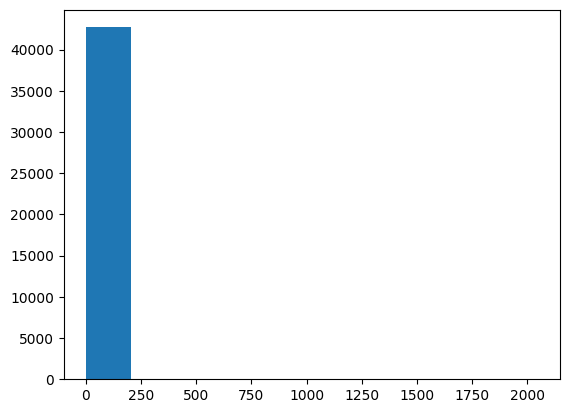

In [91]:
plt.hist(count_missions)
plt.show()

In [92]:
100*count_missions[count_missions > 10].count() / count_missions.shape[0] # % of missions played more than 10 times

0.4986888930511332

In [93]:
100 * (count_missions[(count_missions == 1) | (count_missions == 2)].count() )/ count_missions.shape[0] # % of missions played once or twice

87.75988012736468

Of all pairs of (source, goal) articles (possible missions),  87.76% have been played once or twice only. Less than 1% of missions were played more than 10 times.

In [94]:
player_countM = games.groupby('hashIP').size() # analysing number of missions per player
player_countM.head()

hashIP
000386124f307de8    2
0007183207b6008f    3
000a09e202e88d10    1
000a5bac5b7781ea    1
000a6e585b776c96    1
dtype: int64

In [95]:
player_countM.describe()

count    20867.000000
mean         3.651220
std         34.928749
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       4865.000000
dtype: float64

In [96]:
100*player_countM[player_countM > 5].count() / player_countM.count()

13.044520055590166

13% of players have played more than 5 games. Let's analyse if there is a correlation between the number of played games and % of finished games.

In [100]:
player_percFinish = 100*games.groupby('hashIP')['finished'].sum() / games.groupby('hashIP').size() # percentage of finished missions for each player
player_percFinish.head()

hashIP
000386124f307de8     50.0
0007183207b6008f    100.0
000a09e202e88d10    100.0
000a5bac5b7781ea    100.0
000a6e585b776c96      0.0
dtype: float64

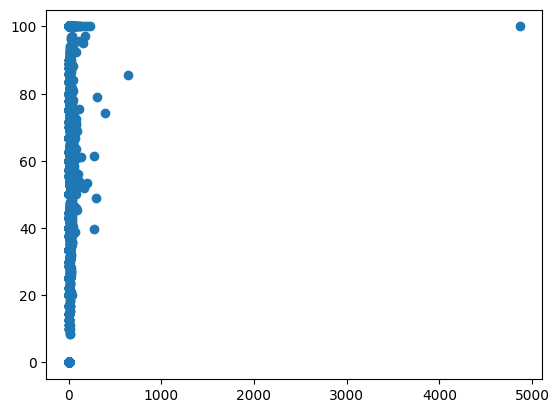

In [101]:
plt.scatter(player_countM, player_percFinish)
plt.show()

In [105]:
player_percFinish.loc[player_countM[player_countM == 4865].index]

hashIP
0d57c8c57d75e2f5    100.0
dtype: float64

There is an outlier in the number of played games: one player played 4865 games. Interestingly, the same player has successfully finished all his missions. Let's look at the previous graph by ignoring this outlier.

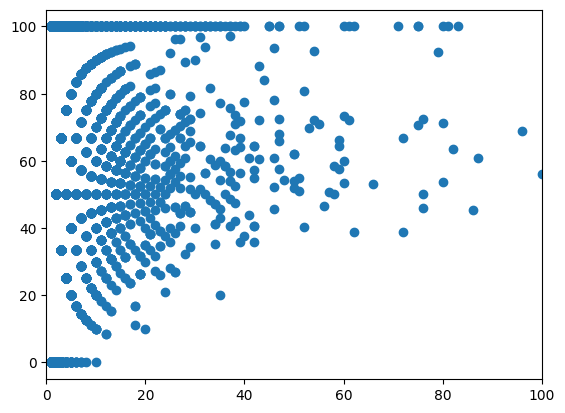

In [131]:
plt.scatter(player_countM, player_percFinish)
plt.xlim(0, 100) # looking only at players with max 100 played games
plt.show()

In [129]:
player_countM.corr(player_percFinish) # looking at all players

0.024809935225090295

In [130]:
player_countM[player_countM <= 100].corr(player_percFinish[player_countM <= 100]) # looking at players that played less than 100 or 100 games

0.10159801682880319

Even when looking at only players with fewer games, it is hard to see a direct correlation between the number of played games and the winrate. Let's see if the distribution of finished VS unfinished games varies a lot between players.

In [117]:
player_percFinish.describe()

count    20867.000000
mean        56.915431
std         43.972501
min          0.000000
25%          0.000000
50%         66.666667
75%        100.000000
max        100.000000
dtype: float64

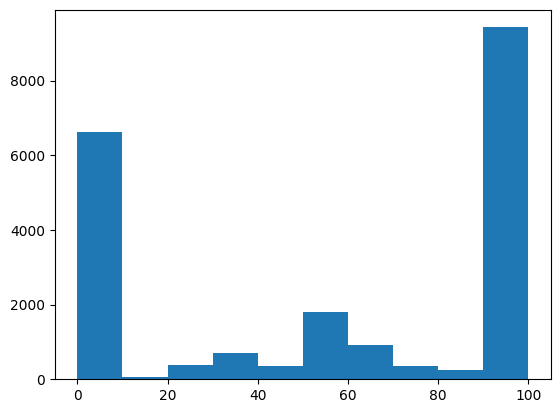

In [118]:
plt.hist(player_percFinish)
plt.show()

In [134]:
print(100 * player_percFinish[player_percFinish == 0].count()/player_percFinish.count(), "% of players have a winrate of 0%, ", 100 * player_percFinish[player_percFinish == 100].count()/player_percFinish.count(), "% of players have a winrate of 100%")

31.739109598888195 % of players have a winrate of 0%,  44.960943115924664 % of players have a winrate of 100%


Let's now see if there is a correlation between the difficulty given by players for a mission and the percentage of games of this missions where people did not succeed. First, we will check how many missions are present in both finished and unfinished paths 

In [85]:
games.head()

,difficulty_rating,duration,finished,hashIP,numBackward,path,path_length,source_article,target_article,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,1297740409,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,1344753412,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,1349298640,NaN
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,1265613925,NaN
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,1366730828,NaN


In [86]:
counts_per_mission = games[['source_article', 'target_article', 'finished']].drop_duplicates().groupby(['source_article', 'target_article']).count()
counts_per_mission.head()
missions_both = counts_per_mission[counts_per_mission['finished'] == 2].reset_index(level=['source_article', 'target_article'])[['source_article', 'target_article']]
missions_both.head() # dataframe containing missions that are both in finished and unfinished paths

,source_article,target_article
0,11th_century,Plum
1,12th_century,Guitar
2,13th_century,Bison
3,13th_century,Olive_oil
4,14th_century,African_slave_trade


In [87]:
100*missions_both.shape[0] / games[['source_article', 'target_article']].drop_duplicates().shape[0]

9.823937066866455

Only 9.82% of possible missions were at least won once and at least lost once by someone. For all these missions, let's collect the number of times they were won, the number of times they were lost, the number of available difficulty ratings and the average difficulty rating (if any).

In [88]:
games_both = games.merge(missions_both, on = ['source_article', 'target_article'], how='inner')
games_both = games_both.groupby(['source_article', 'target_article']).agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_diff = ('difficulty_rating', 'count'), avg_diff = ('difficulty_rating', 'mean'))
games_both.head() # dataframe containing information about games that were won and lost at least once

no_won  no_lost  no_diff  avg_diff
source_article target_article                                         
11th_century   Plum                      1        1        1       1.0
12th_century   Guitar                    4        1        4       3.0
13th_century   Bison                     2        2        2       1.0
               Olive_oil                 1        1        0       NaN
14th_century   African_slave_trade       3        4        1       3.0

In [89]:
100*games_both.query("no_diff == 0").shape[0] / games_both.shape[0]

22.545281220209723

In [90]:
100*games.groupby(['source_article', 'target_article']).count().query("difficulty_rating == 0").shape[0] / games.groupby(['source_article', 'target_article']).count().shape[0] 

52.82122120247237

Out of all games that were at least won and lost once, only 22% have 0 difficulty ratings, which is way lower than when we took into account all played missions, where almost 53% of missions had no difficulty rating.

In [91]:
games_both.describe()

,no_won,no_lost,no_diff,avg_diff
count,4196.000000,4196.000000,4196.000000,3250.000000
mean,3.711153,2.525739,1.742850,2.602552
std,28.930561,27.641620,11.106372,1.049253
min,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000
50%,2.000000,1.000000,1.000000,2.500000
75%,3.000000,2.000000,2.000000,3.000000
max,1043.000000,1004.000000,404.000000,5.000000


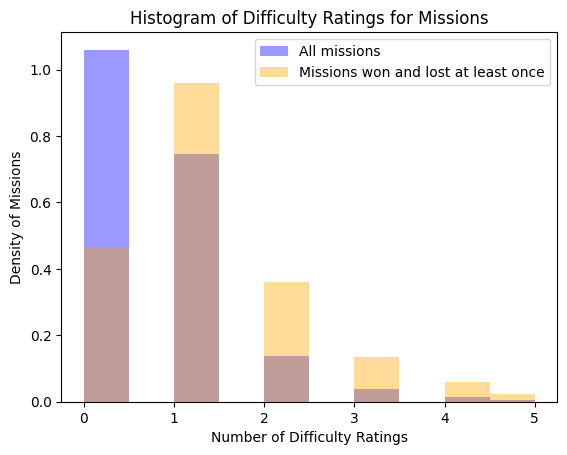

In [106]:
# distribution of count of difficulty ratings per mission in dataframe of all games
games_diff = games.groupby(['source_article', 'target_article']).count()['difficulty_rating'] 

# distribution of count of difficulty ratings per mission in dataframe of games that were at least won and lost once
games_both_diff = games_both['no_diff']

plt.hist(games_diff, range=(0, 5), alpha=0.4, color='blue', label='All missions', density = True)
plt.hist(games_both_diff, range=(0, 5), alpha=0.4, color='orange', label='Missions won and lost at least once', density = True)

plt.xlabel("Number of Difficulty Ratings")
plt.ylabel("Density of Missions")
plt.title("Histogram of Difficulty Ratings for Missions")
plt.legend()

plt.show()

We can see how when looking at games that were at least won and lost once, the distribution of the number of difficulty ratings is more diverse than in the case where we are looking at all the missions, where most of the missions had no difficulty rating.

We can now finally check if there is a correlation between the average difficulty rating and the number of times a game was lost for games that were lost and won at least once.

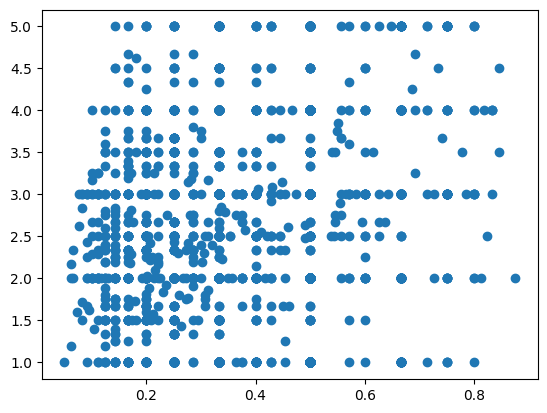

In [93]:
one_diff = games_both[games_both['no_diff'] != 0] # look at games that have at least one difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.show()

In [94]:
perc_lost.corr(one_diff['avg_diff'])

0.1506577927603975

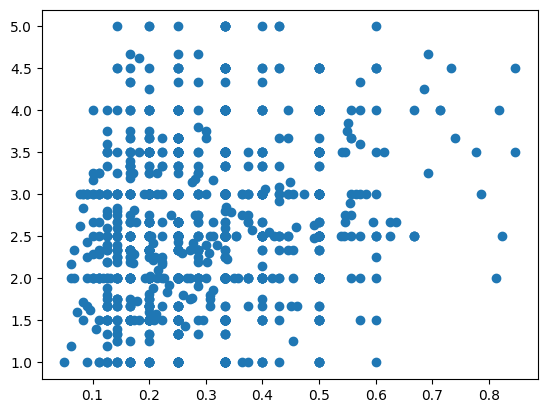

In [95]:
one_diff = games_both[games_both['no_diff'] > 1] # look at games that have at least two difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.show()

In [96]:
perc_lost.corr(one_diff['avg_diff'])

0.20146472763079626

We can see the correlation score is bigger if we take into account only the missions for which we have more difficulty ratings.

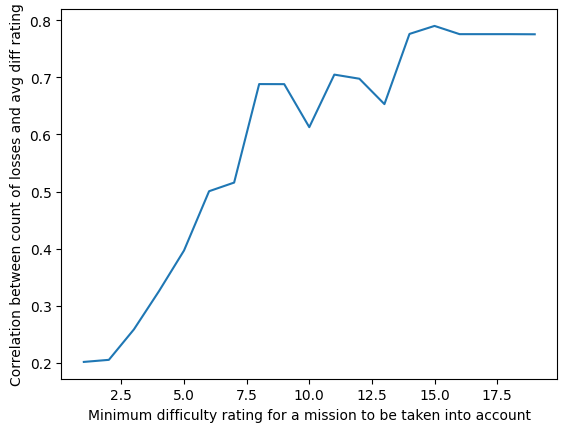

In [97]:
x = range(1, 20)
corr = []
for i in x:
    one_diff = games_both[games_both['no_diff'] > i] # look at games that have at least one difficulty rating
    perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
    corr.append(perc_lost.corr(one_diff['avg_diff']))
plt.plot(x, corr)
plt.xlabel("Minimum difficulty rating for a mission to be taken into account")
plt.ylabel("Correlation between count of losses and avg diff rating")
plt.show()

Until now, we haven't taken into account the player that plays a certain mission. We will now analyse how much does the difficulty rating depend on the player by checking if different players give different difficulty ratings even if they both lost / won the same amount of missions / the same missions.

In [99]:
# creating a dataframe where for each player we have number of wins, losses, number of given diff rating and avg difficulty rating
player_stat = games.groupby('hashIP').agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_rating = ('difficulty_rating', 'count'), avg_rating = ('difficulty_rating', 'mean'))
player_stat.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000a09e202e88d10,1,0,1,3.0
000a5bac5b7781ea,1,0,0,NaN
000a6e585b776c96,0,1,0,NaN


In [100]:
100*player_stat[player_stat['no_rating'] > 0].shape[0] / player_stat.shape[0]

45.87147170173

Only 45% of players gave at least one difficulty rating. FIrst, let's see if we can find something in common for all players that did not give any ranking. Is their distribution of % of won games very different than for players that did give ratings?

In [104]:
perc_distr_noRank = player_stat[player_stat['no_rating'] == 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_noRank.head() # winrate for players that did not give any ranking

perc_distr_Rank = player_stat[player_stat['no_rating'] > 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_Rank.head() # winrate for players that gave at least one rating

hashIP
000386124f307de8    0.5
0007183207b6008f    1.0
000a09e202e88d10    1.0
000bc9fe5640ed31    1.0
000d397013f09039    1.0
dtype: float64

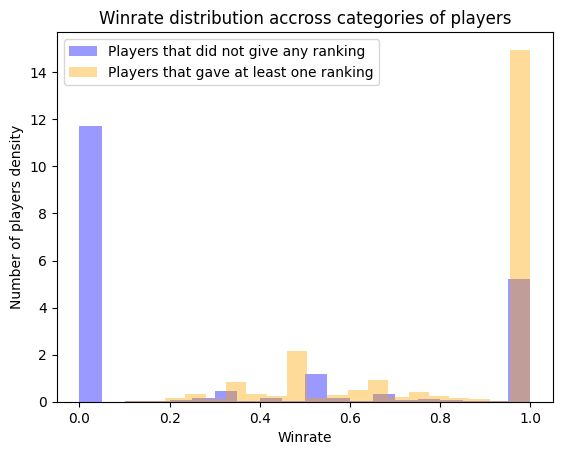

In [109]:
# distribution of winrate accross players
plt.hist(perc_distr_noRank, alpha=0.4, color='blue', bins = 20, label='Players that did not give any ranking', density = True)
plt.hist(perc_distr_Rank, alpha=0.4, color='orange', bins = 20, label='Players that gave at least one ranking', density = True)

plt.xlabel("Winrate")
plt.ylabel("Number of players density")
plt.title("Winrate distribution accross categories of players")
plt.legend()

plt.show()

In [110]:
perc_distr_Rank.describe()

count    9572.000000
mean        0.844325
std         0.242775
min         0.100000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [114]:
perc_distr_noRank[perc_distr_noRank == 0].size / perc_distr_noRank.size # how many have winrate 0 that did not give rating

0.586365648517043

In [115]:
perc_distr_noRank[perc_distr_noRank == 1].size / perc_distr_noRank.size # how many have winrate 1 that did not give rating

0.2606463036741921

In [117]:
perc_distr_Rank[perc_distr_Rank == 1].size / perc_distr_Rank.size # how many have winrate 1 that did give rating

0.6725867112411199

For players that did not give any rating, 58% of them failed all their missions, 26% succeeded all missions, and the rest have a winrate that is between 0 or 1. Players that gave at least one ranking have a winrate of 1 in 67% of cases, but also have a winrate between 0 and 1 more often than players that did not give any ratings. From all players that gave at least one ranking, no one had a winrate of 0.

We will now focus on players that gave ratings and see if the given average rating depends on the winrate (and so, is very similar for players with same winrates) or if it is player dependent (some players tend to give higher / lower ratings).

In [118]:
player_with_rating = player_stat[player_stat['no_rating'] > 0] # information about players that gave at least one rating
player_with_rating.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000a09e202e88d10,1,0,1,3.0
000bc9fe5640ed31,2,0,2,1.0
000d397013f09039,2,0,2,2.0


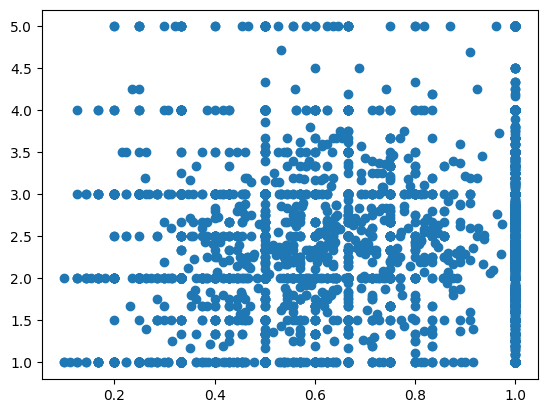

In [119]:
plt.scatter(perc_distr_Rank, player_with_rating['avg_rating']) # showing relationship between winrate and average rating
plt.show()

In [156]:
player_with_rating['winrate'] = player_with_rating.apply(lambda a: a.no_won/(a.no_won + a.no_lost), axis = 1)

C:\Users\bgabe\AppData\Local\Temp\ipykernel_16752\3999462460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_with_rating['winrate'] = player_with_rating.apply(lambda a: a.no_won/(a.no_won + a.no_lost), axis = 1)


C:\Users\bgabe\AppData\Local\Temp\ipykernel_16752\536374785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
C:\Users\bgabe\AppData\Local\Temp\ipykernel_16752\536374785.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()


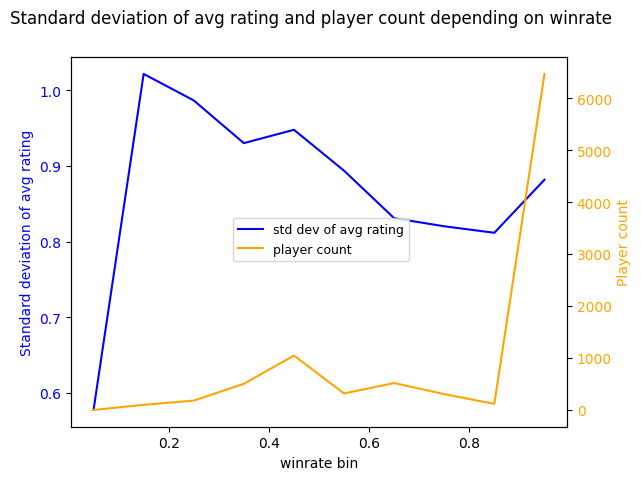

In [174]:
x = np.linspace(0, 1, 11)
player_with_bins = player_with_rating.copy()
player_with_bins['winrate_bin'] = pd.cut(player_with_rating['winrate'], bins=x)

std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()

x = std_devs.index.categories.mid
y_std = std_devs.values
y_count = counts.values

fig, axes = plt.subplots()

axes.plot(x, y_std, color='blue', label='std dev of avg rating')
axes.set_xlabel("winrate bin")
axes.set_ylabel("Standard deviation of avg rating", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, y_count, color='orange', label='player count')
axes2.set_ylabel("Player count", color='orange')
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Standard deviation of avg rating and player count depending on winrate")
fig.legend(loc="center", fontsize = 9)
plt.show()


We can see standard deviation of average rating stays high even when we compare players of same winrate, which means that the average rating depends a lot on the characteristics of a player, and not only on their winrate. F.e. a player may always give higher/lower ratings.

In [166]:
player_with_rating[player_with_rating['winrate'] == 1].head()

,no_won,no_lost,no_rating,avg_rating,winrate,winrate_bin
hashIP,,,,,,
0007183207b6008f,3,0,1,1.0,1.0,"(0.99, 1.0]"
000a09e202e88d10,1,0,1,3.0,1.0,"(0.99, 1.0]"
000bc9fe5640ed31,2,0,2,1.0,1.0,"(0.99, 1.0]"
000d397013f09039,2,0,2,2.0,1.0,"(0.99, 1.0]"
0013e00d2529e52c,7,0,5,2.2,1.0,"(0.99, 1.0]"


In [159]:
perc_distr_Rank.corr( player_with_rating['avg_rating']) # correlation factor between winrate and difficulty rating

-0.01298440657258057

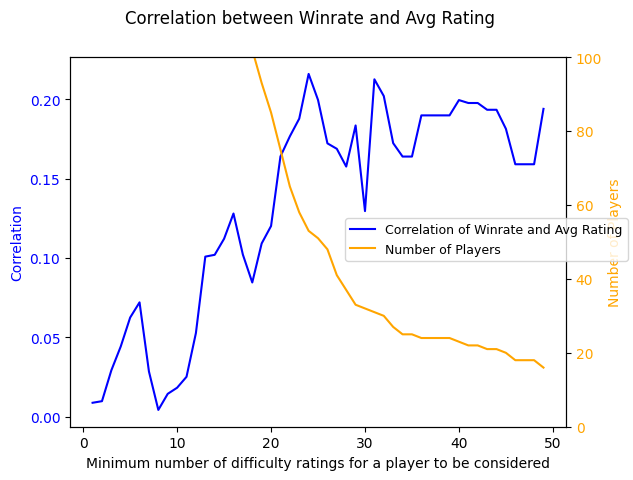

In [175]:
x = range(1, 50)
corr = []
num_players = []

for i in x:
    one_rat = player_with_rating[player_with_rating['no_rating'] > i] # players with at least i given rankings
    perc_lost = one_rat.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis=1) # winrate for them
    corr.append(perc_lost.corr(one_rat['avg_rating'])) # append correlation
    num_players.append(len(one_rat)) # append number of players

fig, axes = plt.subplots()

axes.plot(x, corr, color='blue', label='Correlation of Winrate and Avg Rating')
axes.set_xlabel("Minimum number of difficulty ratings for a player to be considered")
axes.set_ylabel("Correlation", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, num_players, color='orange', label='Number of Players')
axes2.set_ylabel("Number of Players", color='orange')
axes2.set_ylim(0, 100)
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Correlation between Winrate and Avg Rating")
fig.legend(loc="center right", fontsize = 9)
plt.show()


We can see that the correlation between the winrate and avg rating of a player increases when we take into account only players that gave more ratings, but this reduces the number of players from which we can take the data. 

We will now analyse player's ratings not depending on their winrate but by taking specific missions, to see if there are missions for which the differences in user's rankings is higher or very low. 